In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from ray import tune
from torch.utils.data import DataLoader, TensorDataset #, Dataset
# import torch.nn.functional as F

import wandb
import os
from sklearn.decomposition import PCA
import GPUtil
import itertools
import io

from collections import Counter

# Data Loading and Setup:
---

In [2]:
# Loading Data:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_data.csv'
val = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
test = pd.read_csv(file_path)


file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

## GPU Setup:
---

In [3]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 1
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 20653.0 MB
  Memory Used: 3563.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:1
PyTorch current device ID: 1
PyTorch current device name: NVIDIA GeForce RTX 4090


## WandB Setup:
---

In [4]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/models/ims_generator.ipynb'

In [5]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

## Embeddings:
---

In [6]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [7]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

## Spectra:
---

In [8]:
# drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
train_spectra = train.iloc[:,2:-9]
train_chem_encodings = train.iloc[:,-8:]

val_spectra = val.iloc[:,2:-9]
val_chem_encodings = val.iloc[:,-8:]

# create tensors of spectra, true embeddings, and chemical name encodings for train and val
train_chem_labels = list(train['Label'])
train_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in train_chem_labels]).to(device)
train_spectra_tensor = torch.Tensor(train_spectra.values).to(device)
train_chem_encodings_tensor = torch.Tensor(train_chem_encodings.values).to(device)

val_chem_labels = list(val['Label'])
val_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in val_chem_labels]).to(device)
val_spectra_tensor = torch.Tensor(val_spectra.values).to(device)
val_chem_encodings_tensor = torch.Tensor(val_chem_encodings.values).to(device)

# Definitions:
---

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(512,652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652,780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548, 1676),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [10]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_spectra = []
  output_name_encodings = []
  original_spectra = []

  for true_spectra, name_encodings, true_embeddings in train_dataset:
    # move inputs to device
    true_spectra = true_spectra.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_spectra = model(true_embeddings)

    loss = criterion(batch_predicted_spectra, true_spectra)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      for enc, spec, true_spec in zip(name_encodings, batch_predicted_spectra, true_spectra):
        output_name_encodings.append(enc.cpu().detach().numpy())
        predicted_spectra.append(spec.cpu().detach().numpy())
        original_spectra.append(true_spec.cpu().detach().numpy())

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_spectra, output_name_encodings, original_spectra
  else:
    return average_loss

# Running the Generator:
---

## Model Training:
---

In [11]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))
  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [26]:
def plot_results(real_spectra, fake_spectra, chem_encodings, sorted_chem_names, plotting_chem='all', log_wandb=True, idx=[0,5]):
  """
  Plot and compare real and synthetic spectra within a specified index range.

  Takes in real and synthetic spectra and plots them for comparison.
  Computes and prints the weighted cosine similarity between the real spectrum synthetic spectrum.

  Args:
      real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
      fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
      labels (list of str): List of chemical name labels corresponding to each spectrum.
      idx (list of int, optional): Range of indices to plot. Default is [0, 5].
  """
  labels = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_encodings]

  start_num = idx[0]
  stop_num = idx[1]
  
  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plot spectra within the specified index range
    if i > stop_num:
      break
    if start_num <= i < stop_num:
      # if a specific chemical has been specified only plot spectra for that chemical 
      if plotting_chem != 'all':
        if labels[i] != plotting_chem:
          stop_num +=1
          continue
          
      # Define the x-axis range
      numbers = range(0, len(real_spec)//2)

      # Scale the real spectrum so highest peak is 100
      true_spectra_copy = real_spec.copy()

      # Scale the synthetic spectrum so highest peak is 100
      synthetic_spectra_copy = fake_spec.copy()

      weighted_cosine_similarity = get_weighted_cosine_similarity(synthetic_spectra_copy, true_spectra_copy)

      # Create a plot with 2 subplots for real and synthetic spectra
      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].plot(numbers, true_spectra_copy[:len(numbers)], label='Positive')
      ax[0].plot(numbers, true_spectra_copy[len(numbers):], label='Negative')
      ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].plot(numbers, synthetic_spectra_copy[:len(numbers)], label='Positive')
      ax[1].plot(numbers, synthetic_spectra_copy[len(numbers):], label='Negative')
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectra and output spectra is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Drift Time', fontsize=16)
      ax[1].set_ylabel('Ion Intensity', fontsize=16)

      if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'Comparison of Experimental and Synthetic Spectra': wandb.Image('tmp_plot.png')})

      plt.tight_layout()
      plt.show()

Weighted cosine similarity between true spectra and output spectra is:  0.96


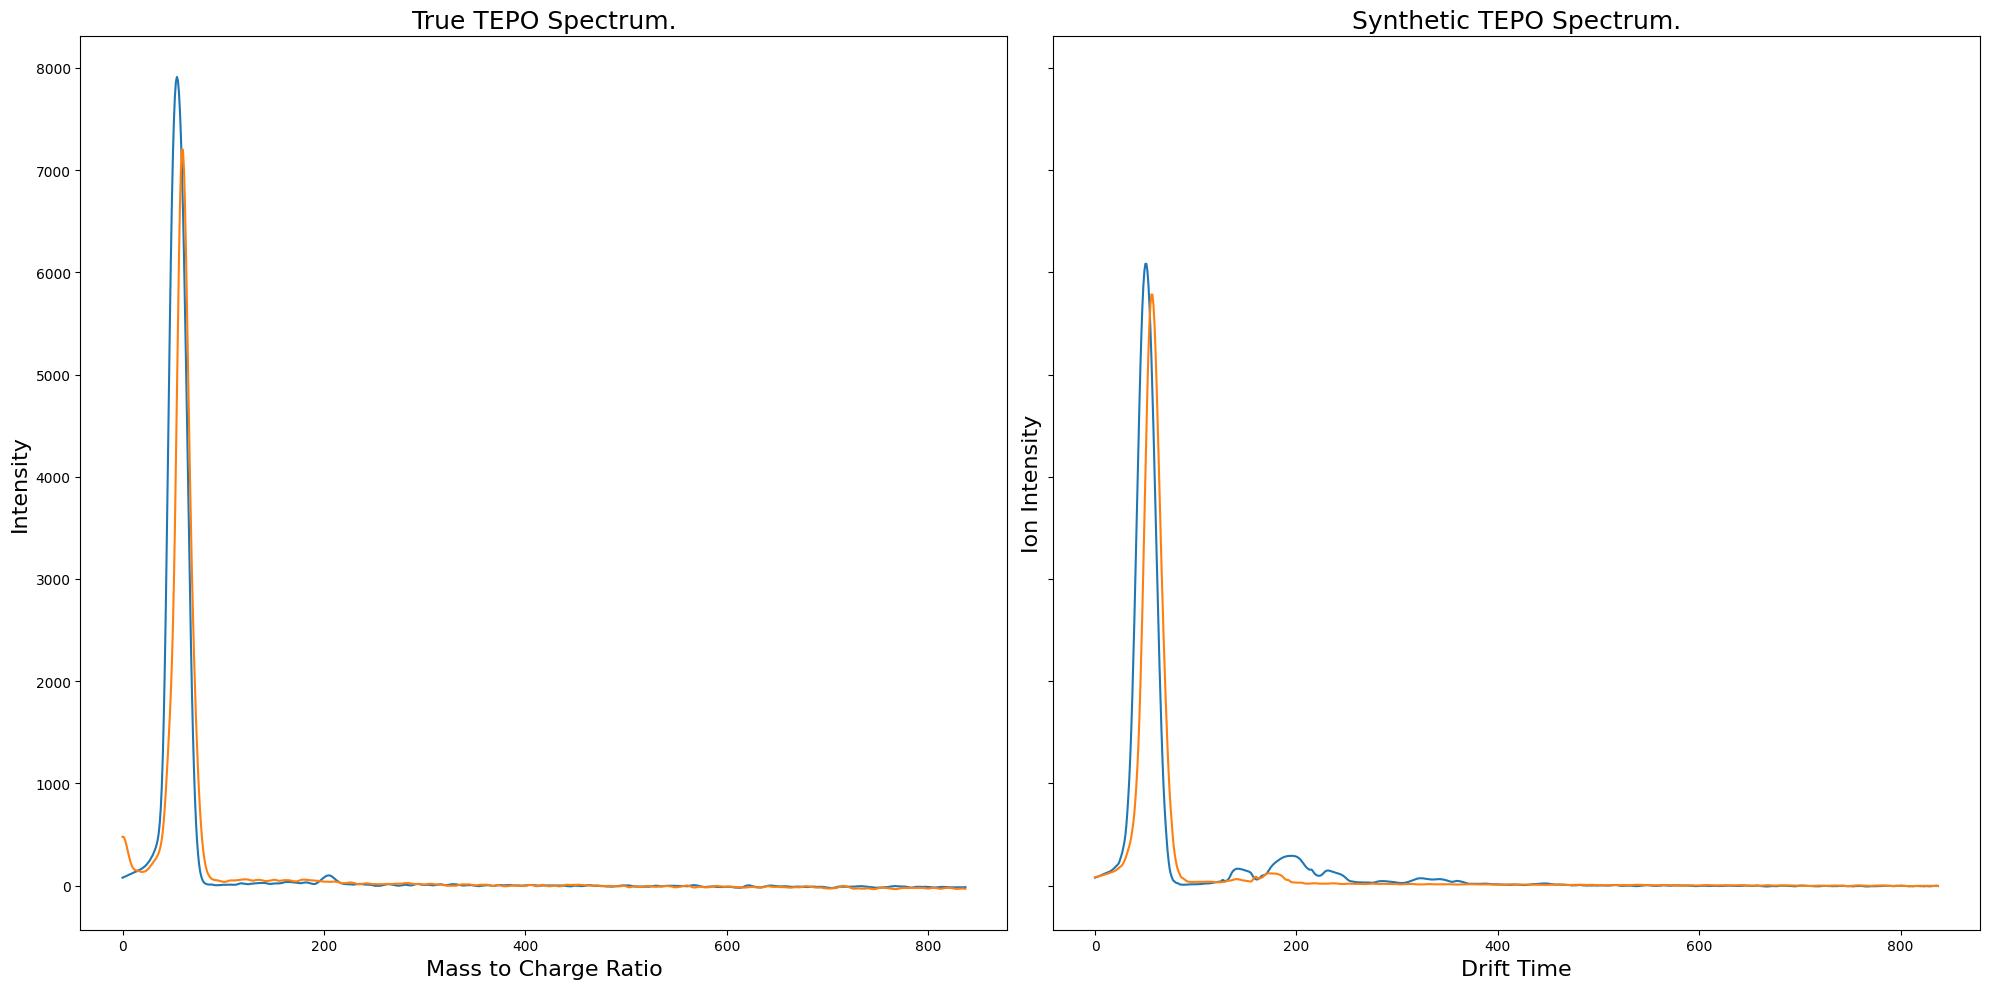

Weighted cosine similarity between true spectra and output spectra is:  0.97


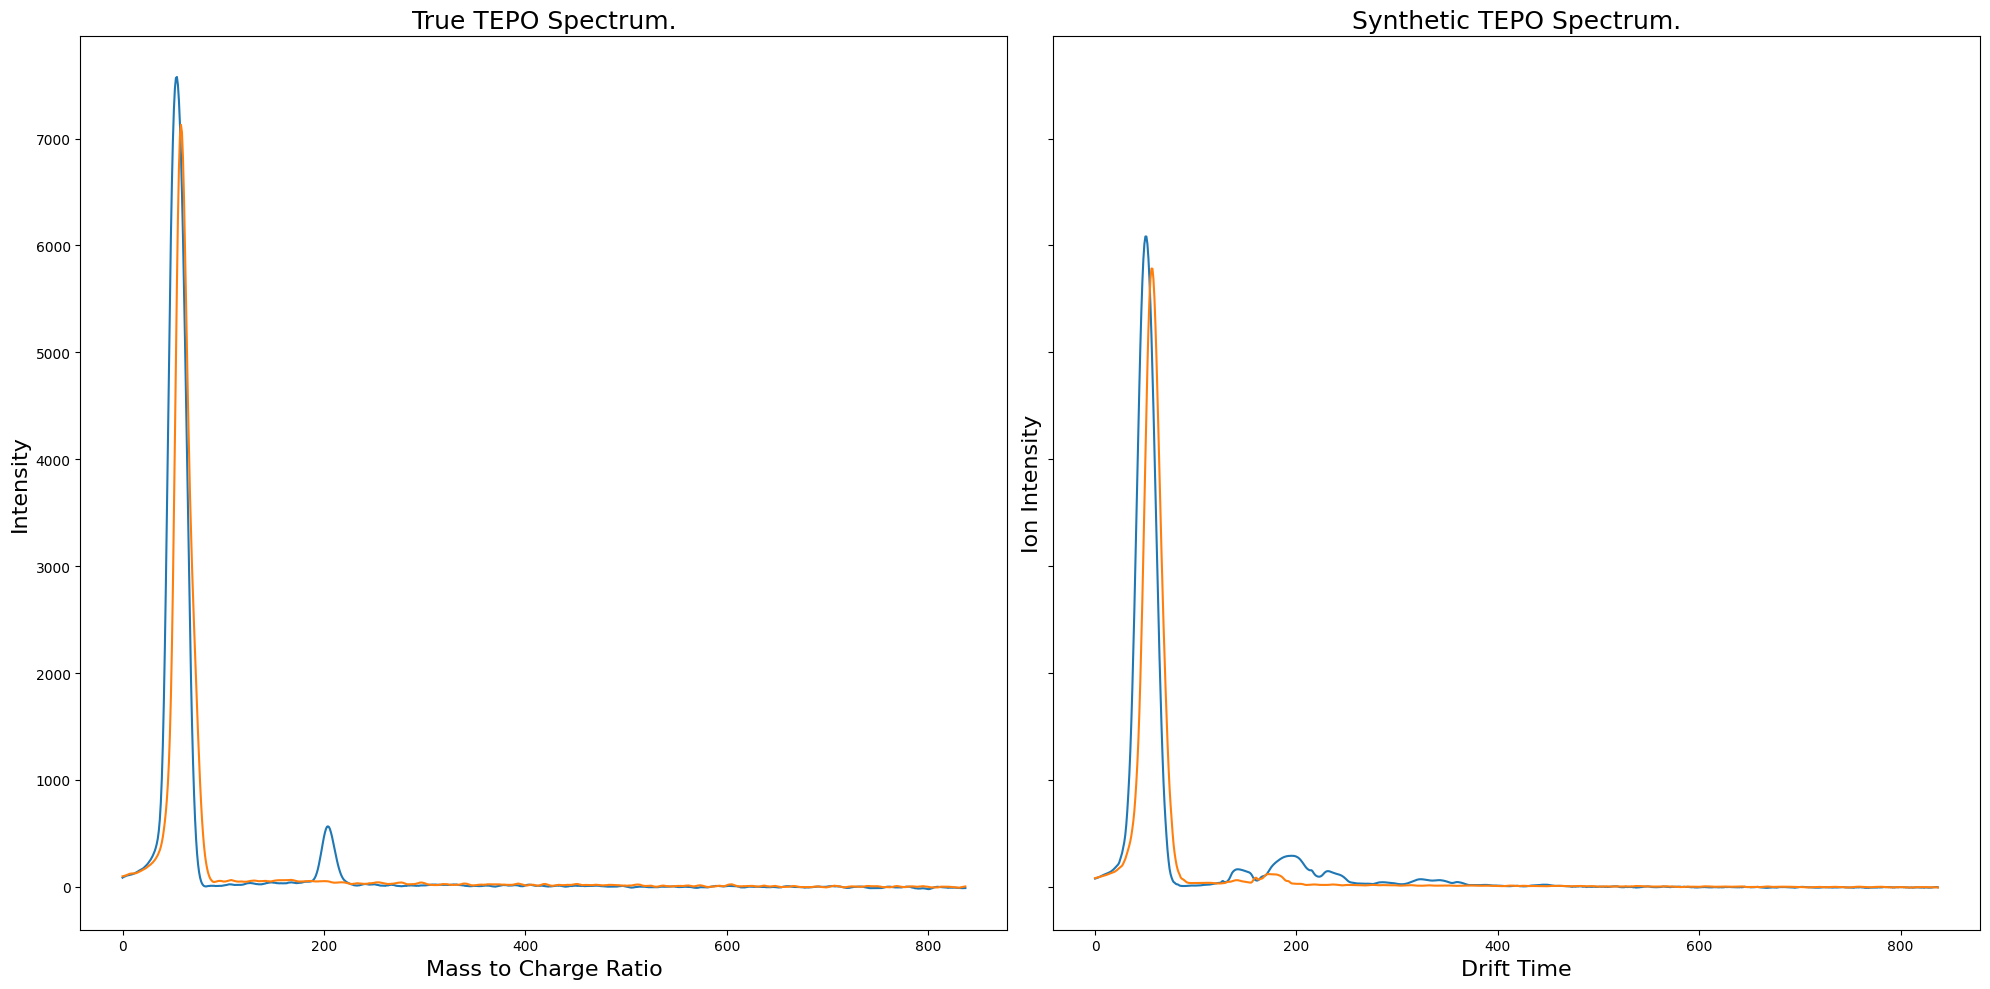

Weighted cosine similarity between true spectra and output spectra is:  0.97


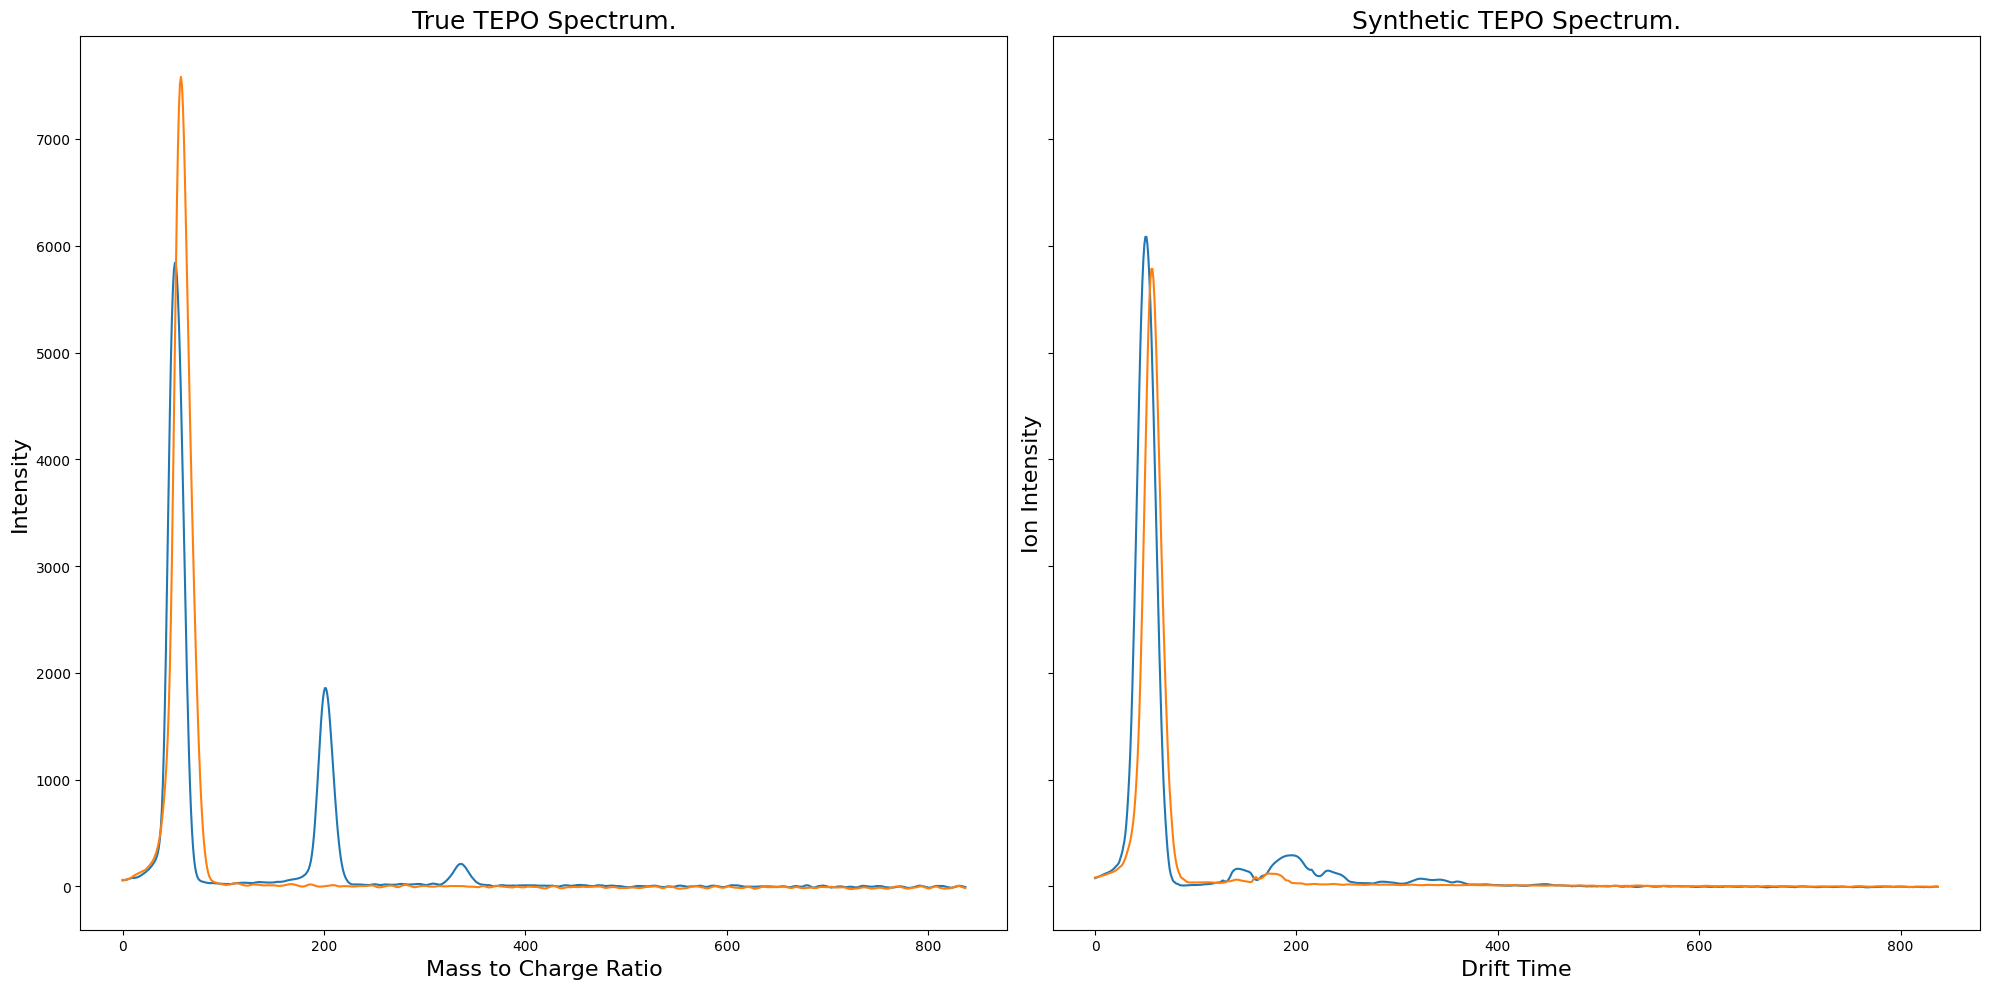

Weighted cosine similarity between true spectra and output spectra is:  0.98


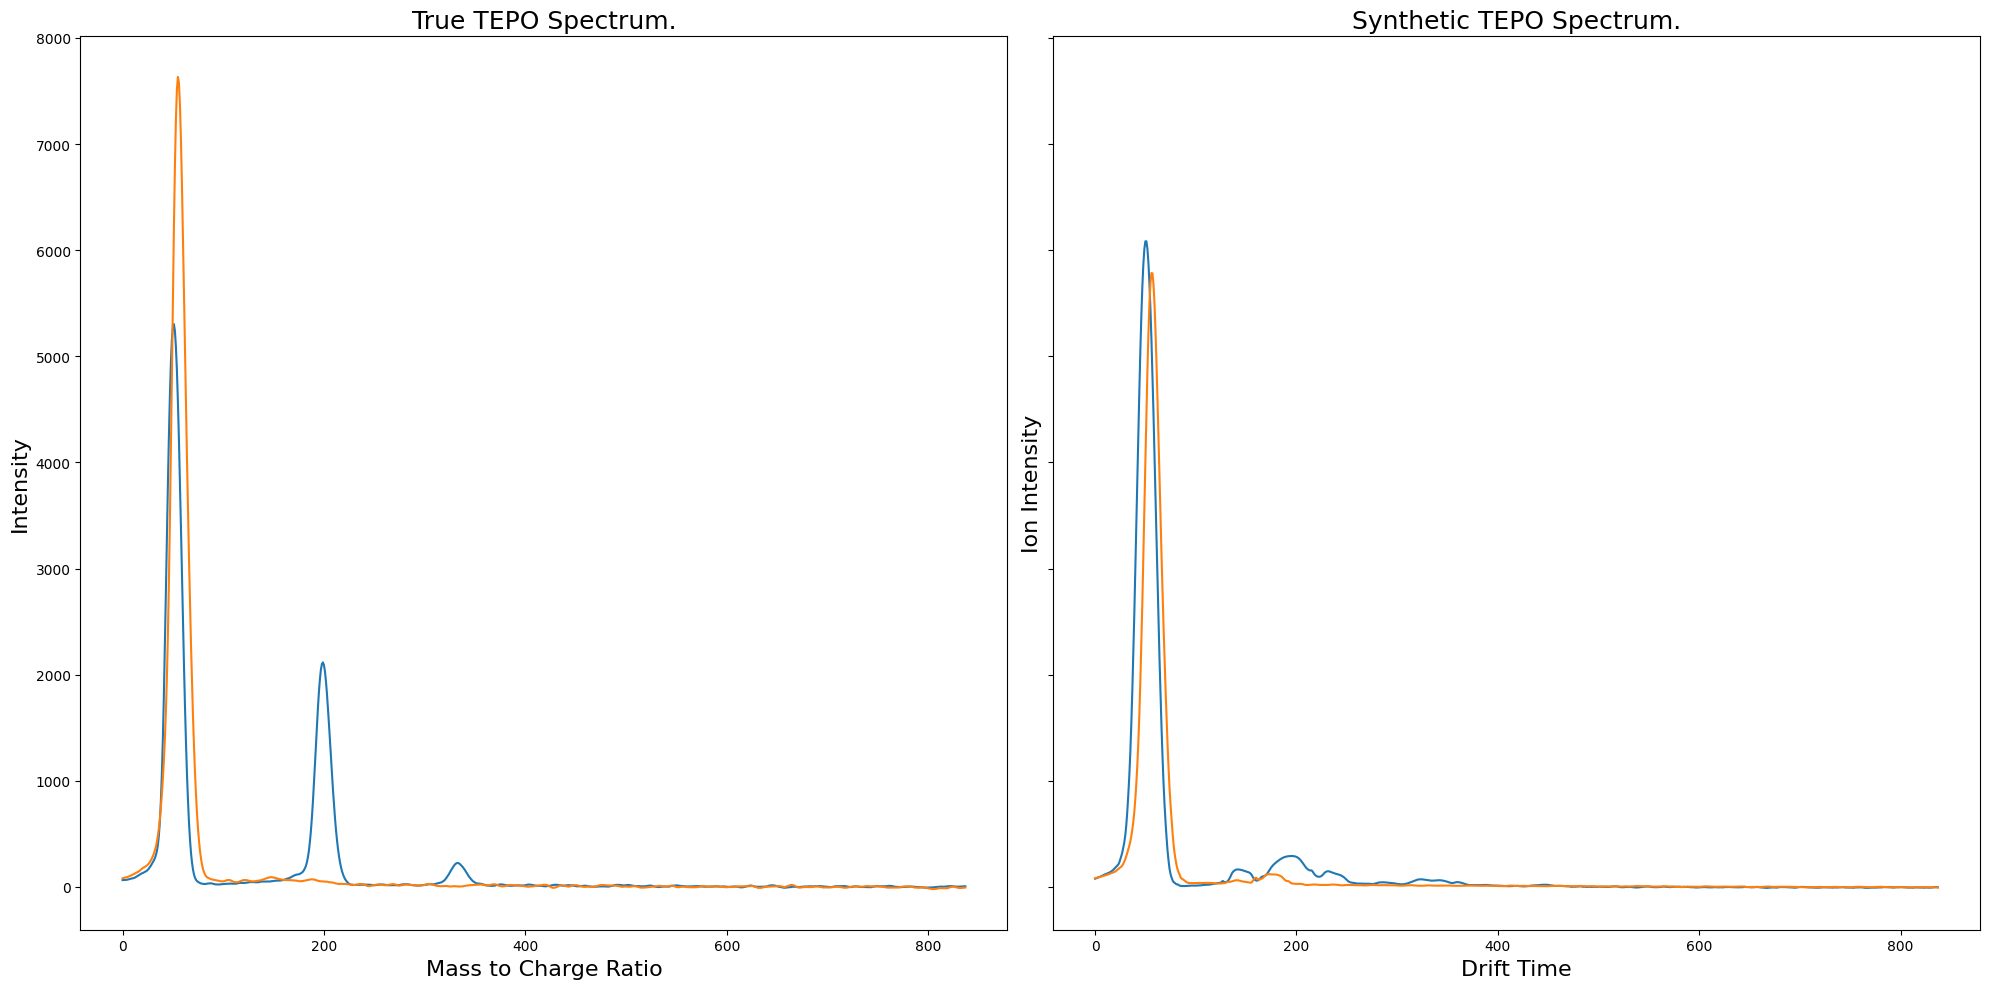

Weighted cosine similarity between true spectra and output spectra is:  0.98


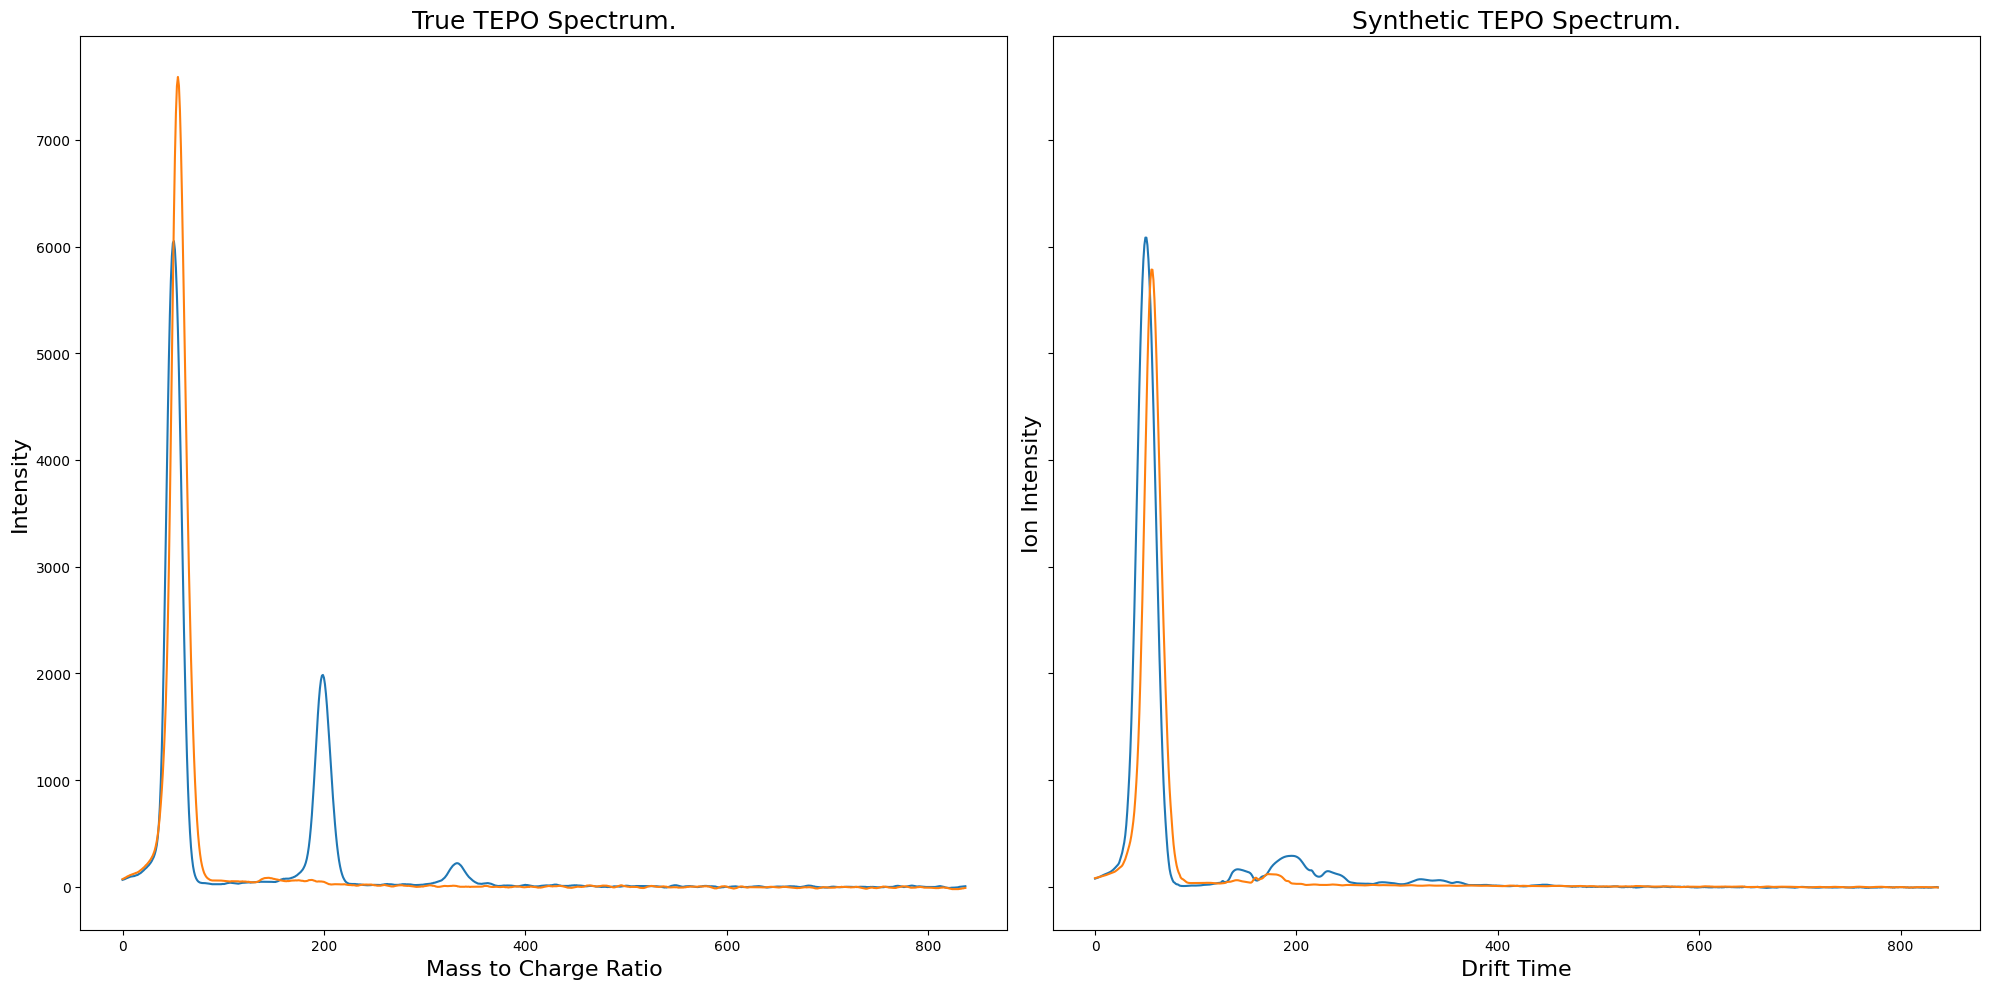

In [28]:
plot_results(original_spectra, predicted_spectra, output_name_encodings, sorted_chem_names, plotting_chem='TEPO', log_wandb=False, idx=[0,5])

In [ ]:
# set var deciding if results plot for this run is saved to wandb
log_wandb = True
# simulant to plot results for. It can be useful to see comparisons for the same simulant
plotting_chem

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train.columns[-8:])

# model_config = {
#   'batch_size':[128, 256],
#   'epochs': [100],
#   'learning_rate':[.01, .001]
  # }

# loss to compare for each model. Starting at something high so it will be replaced by first model's loss 
lowest_loss = 1000000

model_config = {
    'batch_size': [128, 256],
    'epochs': [100],
    'learning_rate': [.001]
}

keys = model_config.keys()
values = model_config.values()

# Generate all parameter combinations from model_config using itertools.product
combinations = itertools.product(*values)

# Iterate through each parameter combination and run model 
for combo in combinations:
  combo = dict(zip(keys, combo))

  train_dataset = DataLoader(TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_embeddings_tensor), batch_size=combo['batch_size'], shuffle=True)
  val_dataset = DataLoader(TensorDataset(val_spectra_tensor, val_chem_encodings_tensor, val_embeddings_tensor), batch_size=combo['batch_size'], shuffle=False)
  generator = Generator().to(device)

  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr = combo['learning_rate'])
  generator_criterion = nn.MSELoss()

  wandb_kwargs = {
    'learning_rate': combo['learning_rate'],
    'epochs': combo['epochs'],
    'batch_size': combo['batch_size'],
    'model_architecture': 'generator',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
  }

  run_with_wandb(config, **wandb_kwargs)

  print('--------------------------')
  print('--------------------------')
  print('New run with hyperparameters:')
  for key in combo:
    print(key, ' : ', combo[key])

  for epoch in range(combo['epochs']):
    # Set model to training mode
    generator.train(True)

    # do a pass over the data
    # at last epoch get predicted embeddings and chem names
    if (epoch + 1) == combo['epochs']:
      average_loss, predicted_spectra, output_name_encodings, original_spectra = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )
    else:
      average_loss = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )

    epoch_val_loss = 0  
    # evaluate model on validation data
    generator.eval() # Set model to evaluation mode
    with torch.no_grad():
      for val_true_spectra, val_name_encodings, val_true_embeddings in val_dataset:
        val_true_spectra = val_true_spectra.to(device)
        val_name_encodings = val_name_encodings.to(device)
        val_true_embeddings = val_true_embeddings.to(device)

        val_batch_predicted_spectra = generator(val_true_embeddings)

        val_loss = generator_criterion(val_batch_predicted_spectra, val_true_spectra)
        # accumulate epoch validation loss
        epoch_val_loss += val_loss.item()

    # divide by number of batches to calculate average loss
    val_average_loss = epoch_val_loss/len(val_dataset)

    # log losses to wandb
    wandb.log({"Generator Training Loss": average_loss, "Generator Validation Loss": val_average_loss})

    if (epoch + 1) % 10 == 0:
      print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
      print(f'   Training loss: {average_loss}')
      print(f'   Validation loss: {val_average_loss}')
      print('-------------------------------------------')

  # saving comparison plots for first 5 spectra
  plot_results(original_spectra, predicted_spectra, output_name_encodings, sorted_chem_names, log_wandb, idx=[0,5])

  if average_loss < lowest_loss:
    best_hyperparams = combo

  wandb.finish()

print('Hyperparameters for best model: ')
for key in best_hyperparams:
  print('   ', key, ' : ', best_hyperparams[key])

Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  128
epochs  :  100
learning_rate  :  0.001


KeyboardInterrupt: 